In [24]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/dataframe_tratado.tsv",sep="\t")
df['VIRUS'] = df['VIRUS'].replace(2, 0)
X = df[[coluna for coluna in df.columns if coluna != "VIRUS"]]
y = df["VIRUS"]

# Dengue: 0
# Chikungunya: 1

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

In [7]:
# Balancear o dataset já que tem muito mais dado de dengue do que de chikungunya

from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
X_res_test, y_res_test = under_sampler.fit_resample(X_test, y_test)

print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 196108, 1: 196108})
Testing target statistics: Counter({0: 582362, 1: 65002})


In [8]:
from xgboost import XGBClassifier

model = XGBClassifier()
# fit the model on the whole dataset
model.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
predito = model.predict(X_res_test)

In [19]:
print('Precision score %s' % precision_score(y_res_test, predito))
print('Recall score %s' % recall_score(y_res_test, predito))
print('F1-score score %s' % f1_score(y_res_test, predito))
print('Accuracy score %s' % accuracy_score(y_res_test, predito))

Precision score 0.7466223972590643
Recall score 0.6503799883080521
F1-score score 0.695186022610483
Accuracy score 0.7148318513276515


In [21]:
def get_confusion_matrix(reais, preditos, labels):
    """
    Uma função que retorna a matriz de confusão normalizada para uma classificação binária
    
    Args:
        reais (list): lista de valores reais
        preditos (list): lista de valores preditos pelo modelos
        labels (list): lista de labels a serem avaliados.
            É importante que ela esteja presente, pois usaremos ela para entender
            quem é a classe positiva e quem é a classe negativa
    
    Returns:
        Um numpy.array, no formato:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    # Normalizar a matriz de confusão
    total_true_class = tp + fn
    total_negative_class = fp + tn
    
    normalized_cf_matrix = np.array([
        [tp / total_true_class, fp / total_negative_class],
        [fn / total_true_class, tn / total_negative_class]
    ])
    
    return normalized_cf_matrix

<Axes: >

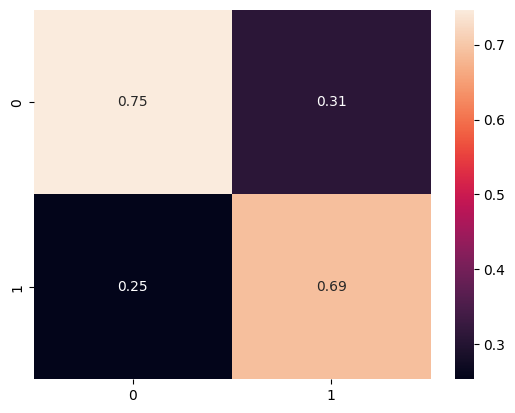

In [22]:
import seaborn as sns
cf_matrix = get_confusion_matrix(reais=y_res_test, preditos=predito, labels=[1,0])
sns.heatmap(cf_matrix, annot=True)

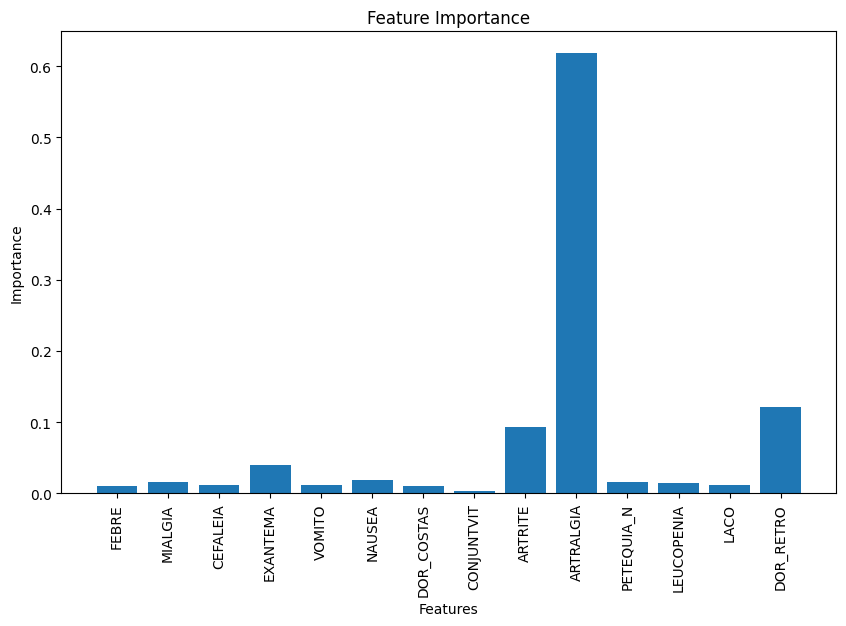

In [25]:
# Obtenha a importância das features
importances = model.feature_importances_

# Crie um gráfico de barras para visualizar as importâncias das features
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X_train.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()